## Quantium Virtual Internship - Retail Strategy and Analytics - Task 1

This Jupyter notebook follows a solution scaffold converted from R for Python for the task provided.

### Load required libraries and datasets

In [2]:
import pandas as pd

In [3]:
# Set up the dataframes
purchase_behaviour_df = pd.read_csv("C:/Users/Jacqu/OneDrive/Documents/Employment/Quantium/QuantiumVEP/Task1/QVI_purchase_behaviour.csv")
transaction_data_df = pd.read_excel("C:/Users/Jacqu/OneDrive/Documents/Employment/Quantium/QuantiumVEP/Task1/QVI_transaction_data.xlsx")

### Exploratory Data Analysis

Let's first examine the transaction data.

In [4]:
# Check if the columns that are expected to be numeric are in numeric form
print("Purchase Behvaiour Datatypes: \n", purchase_behaviour_df.dtypes, "\n")
print("Transaction Data Datatypes: \n", transaction_data_df.dtypes)

Purchase Behvaiour Datatypes: 
 LYLTY_CARD_NBR       int64
LIFESTAGE           object
PREMIUM_CUSTOMER    object
dtype: object 

Transaction Data Datatypes: 
 DATE                int64
STORE_NBR           int64
LYLTY_CARD_NBR      int64
TXN_ID              int64
PROD_NBR            int64
PROD_NAME          object
PROD_QTY            int64
TOT_SALES         float64
dtype: object


We know that if there is mixed datatypes, it will get stored as an object dtype. Thus, the numeric columns are all satisfactory, since they all int64 and float64 dtypes. it can be seen that the date data is stored in integer format, so let's convert it to date time. It is known that Excel dates begin on 30 Dec 1899, so we will use that as the origin.

In [5]:
transaction_data_df["DATE"] = pd.to_datetime(transaction_data_df["DATE"], origin="1899-12-30", unit="D")

# Check if the DATE column is now in the correct format:
transaction_data_df["DATE"].head()

0   2018-10-17
1   2019-05-14
2   2019-05-20
3   2018-08-17
4   2018-08-18
Name: DATE, dtype: datetime64[ns]

Okay so it is in the correct format. Next, let's see a summary of the PROD_NAME column.

In [6]:
transaction_data_df["PROD_NAME"]

0           Natural Chip        Compny SeaSalt175g
1                         CCs Nacho Cheese    175g
2           Smiths Crinkle Cut  Chips Chicken 170g
3           Smiths Chip Thinly  S/Cream&Onion 175g
4         Kettle Tortilla ChpsHny&Jlpno Chili 150g
                            ...                   
264831     Kettle Sweet Chilli And Sour Cream 175g
264832               Tostitos Splash Of  Lime 175g
264833                    Doritos Mexicana    170g
264834     Doritos Corn Chip Mexican Jalapeno 150g
264835               Tostitos Splash Of  Lime 175g
Name: PROD_NAME, Length: 264836, dtype: object

So this definitely looks like we are looking at chips. Let's examine each word in PROD_NAME to see if there are any incorrect entries, such as products that are not chips.

In [7]:
product_words = transaction_data_df["PROD_NAME"].str.split(expand=True).stack().reset_index(drop=True)
product_words_df = pd.DataFrame({"words": product_words})
product_words_df.head()

,words
0,Natural
1,Chip
2,Compny
3,SeaSalt175g
4,CCs


As we are only interested in words that will tell us if the product is chips or not, let's remove all words with digits and special characters such as '&' from our set of product words.

In [8]:
import re
product_words_df = product_words_df[~product_words_df["words"].str.contains(r'\d|[^\w\s]', regex=True)]
product_words_df.head()

,words
0,Natural
1,Chip
2,Compny
4,CCs
5,Nacho


Let's look at the most common words by counting the number of times a word appears and sorting the dataframe 
by this frequency in order of highest to lowest frequency.

In [9]:
word_counts = product_words_df.groupby(['words']).size().reset_index(name='Count').sort_values(['Count'], ascending=False)
word_counts.head(10)

,words,Count
28,Chips,49770
70,Kettle,41288
126,Smiths,28860
117,Salt,27976
18,Cheese,27890
106,Pringles,25102
52,Doritos,24962
41,Crinkle,23960
38,Corn,22063
92,Original,21560


There are also salsa products in the dataset but we are only interested in the chips category, so let's remove these.

In [10]:
# Convert PROD_NAME column to lowercase
transaction_data_df["PROD_NAME"] = transaction_data_df["PROD_NAME"].str.lower()

# Remove salsa products
transaction_data_df= transaction_data_df[~transaction_data_df["PROD_NAME"].str.contains("salsa")]

Next, we can use 'describe()' to check summary statistics such as mean, min and max values for each 
feature to see if there are any obvious outliers in the data, and if there are any nulls in any of
the columns

In [11]:
transaction_data_df.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,2018-12-30 01:19:01.211467520,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828


There are no nulls in the columns but the product quantity appears to have an outlier which we should
investigate further. Let's investigate further the case where 200 packets of chips are bought in one
transaction.

In [12]:
transaction_data_df.sort_values(by=['PROD_QTY'], ascending=False).head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69763,2019-05-20,226,226000,226210,4,dorito corn chp supreme 380g,200,650.0
69762,2018-08-19,226,226000,226201,4,dorito corn chp supreme 380g,200,650.0
135225,2019-05-15,46,46296,42138,81,pringles original crisps 134g,5,18.5
69523,2019-05-15,71,71142,69852,96,ww original stacked chips 160g,5,9.5
69502,2018-08-18,55,55144,49328,44,thins chips light& tangy 175g,5,16.5


There are two transactions where 200 packets of chips are bought in one transaction and both of 
these transactions were made by the same customer. Let's see if the customer has had any other
transactions.

In [13]:
transaction_data_df.loc[transaction_data_df['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,dorito corn chp supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,dorito corn chp supreme 380g,200,650.0


It looks like this customer has only had the two transactions over the year and is
not an ordinary retail customer. The customer might be buying chips for commercial
purposes instead. We'll remove this loyalty card number from further analysis.

In [14]:
transaction_data_df = transaction_data_df.drop(transaction_data_df[transaction_data_df['LYLTY_CARD_NBR'] == 226000].index)

In [15]:
transaction_data_df.sort_values(by=['PROD_QTY'], ascending=False).head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
80732,2019-05-18,49,49309,45816,30,doritos corn chips cheese supreme 170g,5,22.0
17145,2018-08-16,202,202289,202104,42,doritos corn chip mexican jalapeno 150g,5,19.5
117547,2019-05-19,81,81120,80285,46,kettle original 175g,5,27.0
99458,2018-08-17,138,138085,141016,40,thins chips seasonedchicken 175g,5,16.5
28135,2018-08-20,51,51263,46961,3,kettle sensations camembert & fig 150g,5,23.0
32773,2019-05-16,230,230068,232345,100,smiths crinkle cut chips chs&onion170g,5,14.5
99461,2018-08-16,141,141276,142536,25,pringles sourcream onion 134g,5,18.5
99468,2018-08-14,144,144113,144496,15,twisties cheese 270g,5,23.0
81110,2018-08-17,181,181129,183109,23,cheezels cheese 330g,5,28.5
117935,2019-05-14,226,226193,227260,40,thins chips seasonedchicken 175g,5,16.5


That's better. Now, let's look at the number of transaction lines over time to see
if there are any obvious data issues such as missing data.

In [16]:
date_counts = transaction_data_df.groupby(['DATE']).size().reset_index(name='Count').sort_values(['Count'], ascending=False)
print(date_counts.count())
date_counts.head()

DATE     364
Count    364
dtype: int64


,DATE,Count
176,2018-12-24,865
175,2018-12-23,853
174,2018-12-22,840
171,2018-12-19,839
172,2018-12-20,808


There's only 364 rows, meaning only 364 dates which indicates a missing date. Let's
create a sequence of dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a
chart of number of transactions over time to find the missing date.

In [17]:
date_counts.sort_values(by=['DATE'], ascending=True)

,DATE,Count
0,2018-07-01,663
1,2018-07-02,650
2,2018-07-03,674
3,2018-07-04,669
4,2018-07-05,660
...,...,...
359,2019-06-26,657
360,2019-06-27,669
361,2019-06-28,673
362,2019-06-29,703


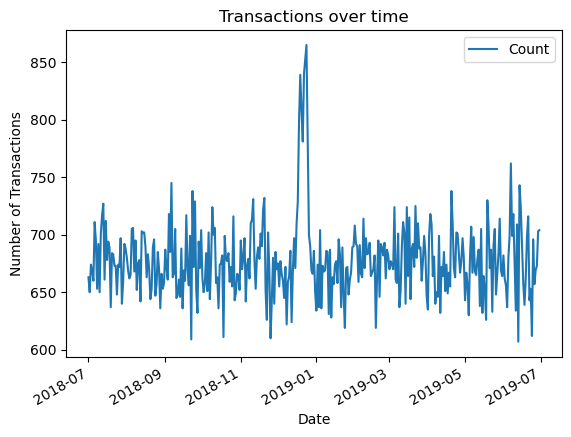

In [18]:
import matplotlib.pyplot as plt
date_counts.plot(x = 'DATE', y = 'Count')
plt.title('Transactions over time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.show()

We can see that there is an increase in purchases in December and a break in late
December. Let's zoom in on this.

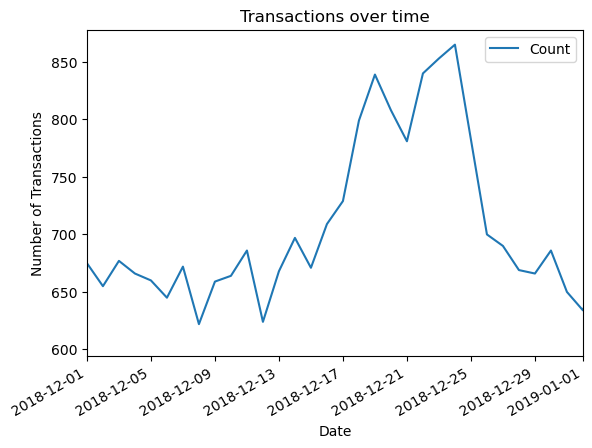

In [19]:
ax = date_counts.plot(x = 'DATE', y = 'Count')
plt.title('Transactions over time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
start_date = pd.to_datetime('2018-12-01')
end_date = pd.to_datetime('2019-01-01')
ax.set_xlim(start_date, end_date)
plt.show()

We can see that the increase in sales occurs in the lead-up to Christmas and that
there are zero sales on Christmas day itself. This is due to shops being closed on
Christmas day.
Now that we are satisfied that the data no longer has outliers, we can move on to
creating other features such as brand of chips or pack size from PROD_NAME. We will
start with pack size.

In [20]:
transaction_data_df['PACK_SIZE'] = transaction_data_df['PROD_NAME'].str.extract("(\d+)").astype(int)
transaction_data_df.head(5)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,2018-10-17,1,1000,1,5,natural chip compny seasalt175g,2,6.0,175
1,2019-05-14,1,1307,348,66,ccs nacho cheese 175g,3,6.3,175
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken 170g,2,2.9,170
3,2018-08-17,2,2373,974,69,smiths chip thinly s/cream&onion 175g,5,15.0,175
4,2018-08-18,2,2426,1038,108,kettle tortilla chpshny&jlpno chili 150g,3,13.8,150


In [21]:
print('Smallest size: ', transaction_data_df.min(axis=0)['PACK_SIZE'], 'g')
print('Largest size: ', transaction_data_df.max(axis=0)['PACK_SIZE'], 'g')

Smallest size:  70 g
Largest size:  380 g


The largest size is 380g and the smallest size is 70g - seems sensible! Let's plot a histogram of PACK_SIZE since we know that it is a categorical variable and not a continuous variable even though it is numeric.

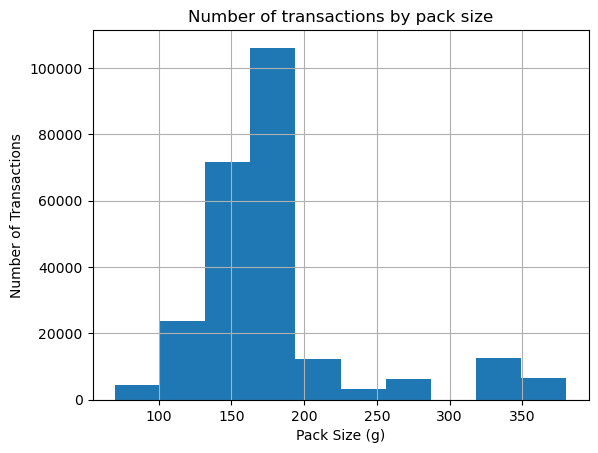

In [22]:
transaction_data_df['PACK_SIZE'].hist()
plt.title('Number of transactions by pack size')
plt.xlabel('Pack Size (g)')
plt.ylabel('Number of Transactions')
plt.show()

Pack sizes created look reasonable.
Now to create brands, we can use the first word in PROD_NAME to work out the brand
name...

In [23]:
transaction_data_df['BRAND'] = transaction_data_df['PROD_NAME'].str.split().str[0]
transaction_data_df.head(5)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND
0,2018-10-17,1,1000,1,5,natural chip compny seasalt175g,2,6.0,175,natural
1,2019-05-14,1,1307,348,66,ccs nacho cheese 175g,3,6.3,175,ccs
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken 170g,2,2.9,170,smiths
3,2018-08-17,2,2373,974,69,smiths chip thinly s/cream&onion 175g,5,15.0,175,smiths
4,2018-08-18,2,2426,1038,108,kettle tortilla chpshny&jlpno chili 150g,3,13.8,150,kettle


Some of the brand names look like they are of the same brands - such as RED and RRD, which are both Red Rock Deli chips. Let's combine these together.

In [24]:
print(transaction_data_df['BRAND'].unique())

['natural' 'ccs' 'smiths' 'kettle' 'grain' 'doritos' 'twisties' 'ww'
 'thins' 'burger' 'ncc' 'cheezels' 'infzns' 'red' 'pringles' 'dorito'
 'infuzions' 'smith' 'grnwves' 'tyrrells' 'cobs' 'french' 'rrd' 'tostitos'
 'cheetos' 'woolworths' 'snbts' 'sunbites']


Some of the brand names look like they are of the same brands - such as RED and
RRD, which are both Red Rock Deli chips. Let's combine these together.

In [25]:
transaction_data_df = transaction_data_df.replace('rrd', 'red')
transaction_data_df = transaction_data_df.replace('grnwves', 'grain')
transaction_data_df = transaction_data_df.replace('ww', 'woolworths')
transaction_data_df = transaction_data_df.replace('snbts', 'sunbites')
transaction_data_df = transaction_data_df.replace('infzns', 'infuzions')

In [26]:
print(transaction_data_df['BRAND'].unique())

['natural' 'ccs' 'smiths' 'kettle' 'grain' 'doritos' 'twisties'
 'woolworths' 'thins' 'burger' 'ncc' 'cheezels' 'infuzions' 'red'
 'pringles' 'dorito' 'smith' 'tyrrells' 'cobs' 'french' 'tostitos'
 'cheetos' 'sunbites']


Next, let's have a look at the cusotmer data set.

In [27]:
print(purchase_behaviour_df.head(10))
print(purchase_behaviour_df['LIFESTAGE'].unique())
print(purchase_behaviour_df['PREMIUM_CUSTOMER'].unique())

   LYLTY_CARD_NBR               LIFESTAGE PREMIUM_CUSTOMER
0            1000   YOUNG SINGLES/COUPLES          Premium
1            1002   YOUNG SINGLES/COUPLES       Mainstream
2            1003          YOUNG FAMILIES           Budget
3            1004   OLDER SINGLES/COUPLES       Mainstream
4            1005  MIDAGE SINGLES/COUPLES       Mainstream
5            1007   YOUNG SINGLES/COUPLES           Budget
6            1009            NEW FAMILIES          Premium
7            1010   YOUNG SINGLES/COUPLES       Mainstream
8            1011   OLDER SINGLES/COUPLES       Mainstream
9            1012          OLDER FAMILIES       Mainstream
['YOUNG SINGLES/COUPLES' 'YOUNG FAMILIES' 'OLDER SINGLES/COUPLES'
 'MIDAGE SINGLES/COUPLES' 'NEW FAMILIES' 'OLDER FAMILIES' 'RETIREES']
['Premium' 'Mainstream' 'Budget']


Okay so upon initial inspection, this seems reasonable. Let's check for nulls.

In [28]:
purchase_behaviour_df.isnull().values.any()

False

This means there are no null values in this dataframe. Let's make a histogram to see what the distribution
of customer type is.

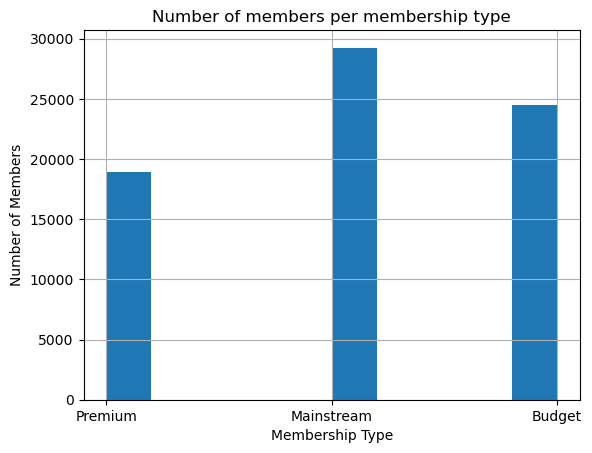

In [29]:
purchase_behaviour_df['PREMIUM_CUSTOMER'].hist()
plt.title('Number of members per membership type')
plt.xlabel('Membership Type')
plt.ylabel('Number of Members')
plt.show()

Now, let's merge the transaction data to the customer data

In [30]:
# Perform a left join merge
data = pd.merge(transaction_data_df, purchase_behaviour_df, on='LYLTY_CARD_NBR', how='left')

Let's also check if some customers were not matched on by checking for nulls.

In [31]:
null_mask = data.isnull().any(axis=1)
null_rows = data[null_mask]
print(null_rows)

Empty DataFrame
Columns: [DATE, STORE_NBR, LYLTY_CARD_NBR, TXN_ID, PROD_NBR, PROD_NAME, PROD_QTY, TOT_SALES, PACK_SIZE, BRAND, LIFESTAGE, PREMIUM_CUSTOMER]
Index: []


Great, there are no nulls! So all our customers in the transaction data has been
accounted for in the customer dataset. Let's retain this dataset for use later, so save it as a csv file.

In [32]:
data.to_csv("QVI_data.csv")

Data exploration is now complete! Now that the data is ready for analysis, we can define some
metrics of interest to the client:
- Who spends the most on chips (total sales), describing customers by lifestage and
how premium their general purchasing behaviour is
- How many customers are in each segment
- How many chips are bought per customer by segment
- What's the average chip price by customer segment

We could also ask our data team for more information. Examples are:
- The customer's total spend over the period and total spend for each transaction
to understand what proportion of their grocery spend is on chips
- Proportion of customers in each customer segment overall to compare against the
mix of customers who purchase chips

Let's start with calculating total sales by LIFESTAGE and PREMIUM_CUSTOMER and
plotting the split by these segments to describe which customer segment contribute
most to chip sales.

In [33]:
sales_data = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum()

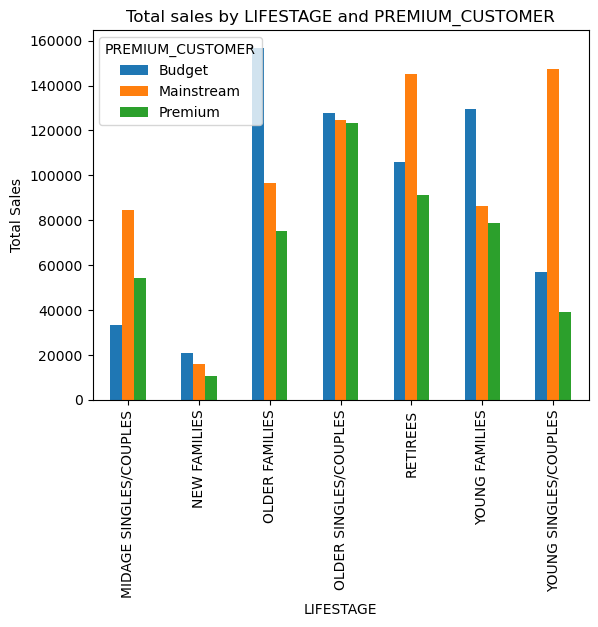

In [34]:
sales_data.unstack().plot(kind='bar')
plt.title("Total sales by LIFESTAGE and PREMIUM_CUSTOMER")
plt.xlabel("LIFESTAGE")
plt.ylabel("Total Sales")
plt.show()

Sales are coming mainly from:
- Budget - older families
- Mainstream - young singles/couples
- Mainstream - retirees

Let's see if the higher sales are due to there being more customers who buy chips.

In [35]:
customer_counts = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique()

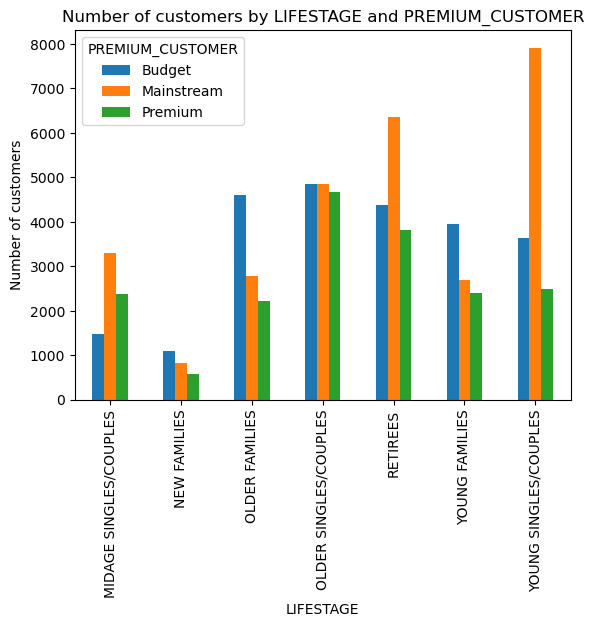

In [36]:
customer_counts.unstack().plot(kind='bar')
plt.title("Number of customers by LIFESTAGE and PREMIUM_CUSTOMER")
plt.xlabel("LIFESTAGE")
plt.ylabel("Number of customers")
plt.show()

There are more mainstream - young singles/couples and Mainstream - retirees who buy chips. This
contributes to there being more sales to these customer segments but this is not a major driver for
the Budget - Older families segment.

Higher sales may also be driven by more units of chips being bought per customer. Let's have a look
at this next.

In [37]:
grouped_data = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])
avg_units_per_customer = grouped_data['PROD_QTY'].sum() / grouped_data['LYLTY_CARD_NBR'].nunique()

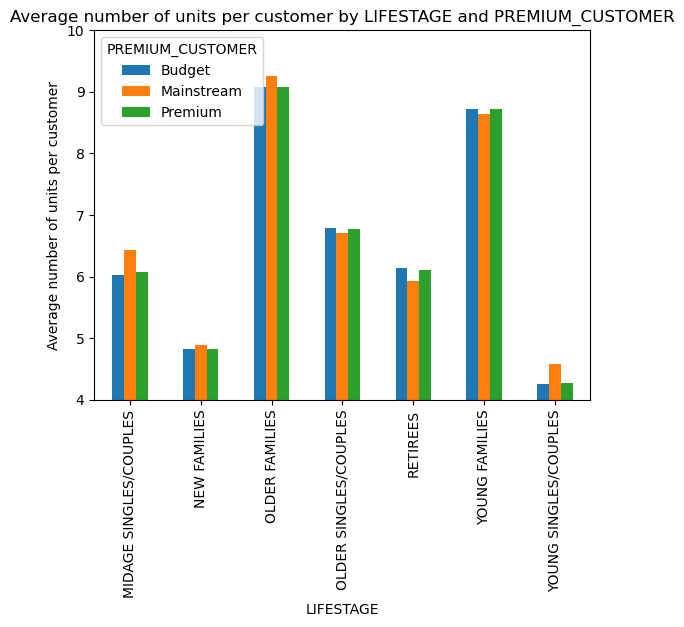

In [38]:
avg_units_per_customer.unstack().plot(kind='bar')
plt.title('Average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER')
plt.xlabel('LIFESTAGE')
plt.ylabel('Average number of units per customer')
plt.ylim(4, 10)
plt.show()

Older families and young families in general buy more chips per customer.

Let's also investigate the average price per unit chips bought for each customer
segment as this is also a driver of total sales.

In [39]:
total_sales = grouped_data['TOT_SALES'].sum()
total_units = grouped_data['PROD_QTY'].sum()
avg_price_per_unit = total_sales / total_units

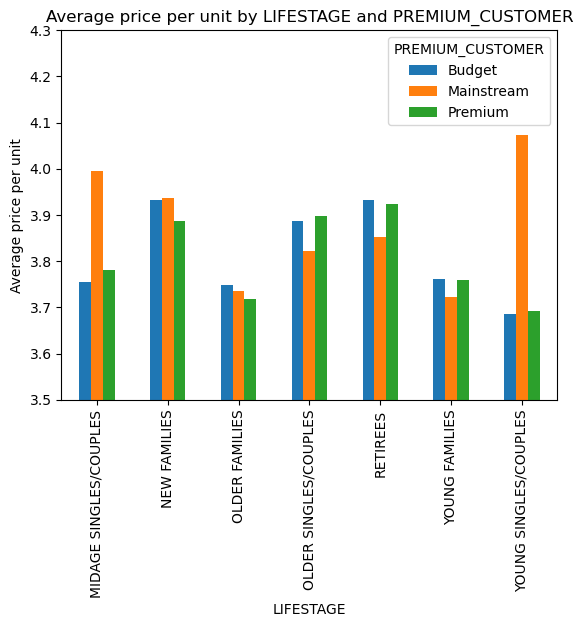

In [40]:
avg_price_per_unit.unstack().plot(kind='bar')
plt.title('Average price per unit by LIFESTAGE and PREMIUM_CUSTOMER')
plt.xlabel('LIFESTAGE')
plt.ylabel('Average price per unit')
plt.ylim(3.5, 4.3)
plt.show()

Mainstream midage and young singles and couples are more willing to pay more per
packet of chips compared to their budget and premium counterparts. This may be due
to premium shoppers being more likely to buy healthy snacks and when they buy
chips, this is mainly for entertainment purposes rather than their own consumption.
This is also supported by there being fewer premium midage and young singles and
couples buying chips compared to their mainstream counterparts.

As the difference in average price per unit isn't large, we can check if this difference is 
statistically different.

In [47]:
data['PRICE_PER_UNIT'] = data['TOT_SALES'] / data['PROD_QTY']

In [48]:
mainstream = data[(data['PREMIUM_CUSTOMER'] == 'Mainstream') 
                & (data['LIFESTAGE'].str.contains('MIDAGE SINGLES/COUPLES|YOUNG SINGLES/COUPLES'))]
premium_budget = data[(data['PREMIUM_CUSTOMER'].str.contains('Premium|Budget')) 
                & (data['LIFESTAGE'].str.contains('MIDAGE SINGLES/COUPLES|YOUNG SINGLES/COUPLES'))]

Let's perform the t-test.

In [49]:
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(mainstream['PRICE_PER_UNIT'], premium_budget['PRICE_PER_UNIT'])
print('P value is: ', p_value)

P value is:  2.235645611549355e-309


The t-test results in a p-value of 2.235e-309, i.e. the unit price for mainstream, young and mid-age singles and couples ARE NOT significantly higher than that of budget or premium, young and midage singles and couples.

We have found quite a few interesting insights we cna dive dedeper into.

We might want to target customer segments that contribute the most to sales to retain them or further increase sales. Let's look at Mainstream - young singles/couples. For instance, let's find out if they tend to buy a particular brand of chips.

In [50]:
young_data = data[(data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Mainstream')]
young_data.head(4)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,PRICE_PER_UNIT
221345,2018-08-16,1,1020,26,19,smiths crinkle cut snag&sauce 150g,1,2.6,150,smiths,YOUNG SINGLES/COUPLES,Mainstream,2.6
221346,2018-08-17,1,1163,188,46,kettle original 175g,1,5.4,175,kettle,YOUNG SINGLES/COUPLES,Mainstream,5.4
221347,2018-08-14,1,1291,333,27,ww supreme cheese corn chips 200g,1,1.9,200,woolworths,YOUNG SINGLES/COUPLES,Mainstream,1.9
221348,2019-05-15,3,3031,1227,14,smiths crnkle chip orgnl big bag 380g,1,5.9,380,smiths,YOUNG SINGLES/COUPLES,Mainstream,5.9


In [51]:
brand_counts = young_data['BRAND'].value_counts()
brand_counts.head(5)

BRAND
kettle       3844
pringles     2315
doritos      2076
smiths       1790
infuzions    1250
Name: count, dtype: int64

Okay so the top 5 brands purchased by Mainstream - young singles/couples are:
1. kettle
2. pringles
3. doritos
4. smiths
5. infuzions

This makes sense due to the fact that these brands are also qualitatively the most popular brands.
We can convert the data into a normal distribution to see how much more units of chips are purchased compared to other brands.

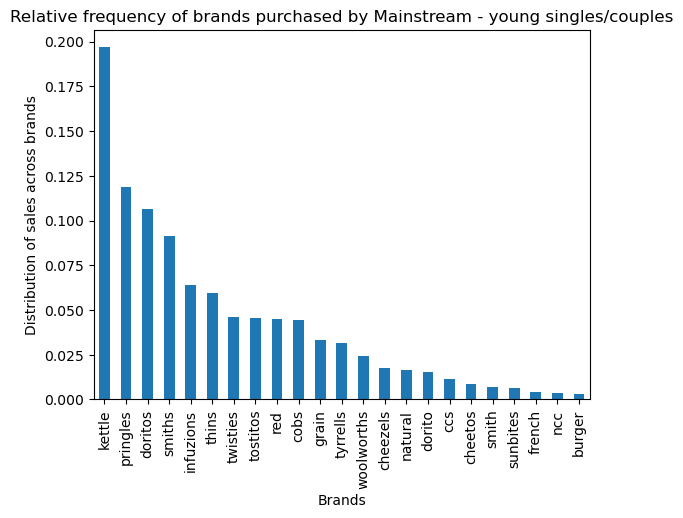

In [52]:
normalised_brand_counts = brand_counts / brand_counts.sum()
normalised_brand_counts.columns = ['BRAND', 'NORMALISED_COUNT']
normalised_brand_counts.plot(x='BRAND', y='RELATIVE_FREQUENCY', kind='bar')
plt.title('Relative frequency of brands purchased by Mainstream - young singles/couples')
plt.xlabel('Brands')
plt.ylabel('Distribution of sales across brands')
plt.show()